# Generating data by sampling from the latent space of a conditional autoencoder

## Intro
By providing the decoder of an autoencoder the class label, the encoder's representations of the data can be more easily controlled and sampled from given that we want class-specific samples. Here I use the MNIST dataset of handwritten digits. It is a large dataset and relatively simple.

A regularization term is added to the encoded layer, which ensures that the representations of all x in X get mapped to a fairly small region in the latent space close to the origin, regardless of their class. The *exact oppossite* is aimed for when we wish to draw random samples from the space class notwithstanding: see [here](https://ekamperi.github.io/machine%20learning/2021/01/21/encoder-decoder-model.html), where the ideal is that the representation regions separate well while the space itself remains reasonably compact.

When we want the conditioning label to be the driving signal, the ideal case is that all class representations stay independent in and densely populate a small region around the origin. While the regularization term causes a bit of a bottleneck in differentiating "types" of members of the same class by forcing the space to be small and the classes to overlap, in practice the class representations still become somewhat interdependent as we see in the other notebooks.

[This](http://jck.bio/disentangling_a_latent_space/) is a great read on entanglement in latent spaces albeit of a much larger scope than that of this project.

## Preliminary stuff

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from keras import layers, losses, optimizers, regularizers, models, Model, utils
from keras.callbacks import Callback

#### Choosing the size of the latent space and whether or not to use batch-normalization on the encoder's outputs
(the reason for batchnorm becomes apparent in the vis10d notebook)

In [2]:
LATSIZE = 10
batchnorm = False

#### Loading in the dataset
I have the MNIST dataset saved as a csv file for the sake of convenience, although on Keras it's one of a handful of datasets accessible through class methods.  
The class label here is converted to a one-hot encoded array so that it can be concatenated to the latent representation layer.

In [3]:
train_df = pd.read_csv("mnist/mnist_train.csv", header=None)
train_x = np.array(train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1)))
train_x = train_x/255.
train_y = np.array(train_df.iloc[:, 0].to_numpy().reshape((-1, 1)))
train_y = utils.to_categorical(train_y)

#### Custom callback
The callback takes the outputs of the encoder given a handful of samples from the dataset, and logs them at the end of every batch during training to see how the classes find their regions in the space. This data is used in the other notebooks.

In [4]:
class Encodings(Callback):
    def __init__(self, enc):
        super().__init__()
        self.enc = enc
        self.epochlogs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epochlog = {}
        for i in range(10):
            self.epochlog[i] = [[] for _ in range(LATSIZE)]

    def on_train_batch_end(self, batch, logs={}):
        samples = []
        for dig in range(10):
            ind = random.choice(range(len(train_x)))
            while np.argmax(train_y[ind]) != dig:
                ind = random.choice(range(len(train_x)))
            samples.append(train_x[ind])

        samples = np.array(samples).reshape((10, 28, 28, 1))
        preds = self.enc.predict(samples, verbose=0)
        for pred, label in zip(preds, range(10)):
            for i in range(LATSIZE):
                self.epochlog[label][i].append(pred[i].item())

    def on_epoch_end(self, epoch, logs=None):
        self.epochlogs.append(self.epochlog)
        self.epochlog = {}

    def on_train_end(self, logs=None):
        self.epochlogs = np.array(self.epochlogs)
        if batchnorm:
            np.save(f"saves/{LATSIZE}d_points_batchnorm", self.epochlogs, allow_pickle=True)
        else:
            np.save(f"saves/{LATSIZE}d", self.epochlogs, allow_pickle=True)

        print(self.epochlogs.size, self.epochlogs.shape)

#### The model  
Note that layer `dec_inp` concatenates the encoder's output (the low-dimensional latent representation) with the one-hot encoded array which provides the class label. 

In [5]:
input0 = layers.Input((28, 28, 1))
input1 = layers.Input((10, ))

x0 = layers.Conv2D(16, 14, 2)(input0)
x0 = layers.MaxPool2D()(x0)
x0 = layers.Flatten()(x0)
x0 = layers.Dense(128, activation="relu")(x0)
x0 = layers.Dense(16, activation="relu")(x0)

if batchnorm:
    x0 = layers.BatchNormalization()(x0)

x0 = layers.Dense(LATSIZE,
                  activation="linear",
                  activity_regularizer=regularizers.l2(l2=0.002),
                  use_bias=False
                  )(x0)

dec_inp = layers.Concatenate(name="concat")([x0, input1])
dec = layers.Dense(256, activation="relu")(dec_inp)
dec = layers.Dense(512, activation="relu")(dec)
dec = layers.Dense(28 * 28, activation="sigmoid", use_bias=False)(dec)

outputs = layers.Reshape((28, 28, 1))(dec)

Notice that the training model trains on two losses with loss weights. Repeating outputs is not the right implementation but here it's convenient.

In [6]:
train_model = Model(inputs=[input0, input1], outputs=[outputs, outputs])
train_model.compile(
    optimizers.Adam(learning_rate=0.001),
    loss=[losses.BinaryCrossentropy(), losses.MeanAbsoluteError()],
    loss_weights=[0.2, 1]
)

The encoder is passed as callback for the purpose explained above.  
While 50 is way more epochs than needed, it makes the plots in the later notebooks look nicer.

In [7]:
encoder = Model(inputs=input0, outputs=x0)
train_model.fit([train_x, train_y], [train_x, train_x], epochs=50, batch_size=256, verbose=1, callbacks=Encodings(encoder))

Epoch 1/50
235/235 [==============================] - 25s 101ms/step - loss: 0.1790 - reshape_loss: 0.2571 - reshape_1_loss: 0.1231
Epoch 2/50
235/235 [==============================] - 24s 100ms/step - loss: 0.1077 - reshape_loss: 0.1712 - reshape_1_loss: 0.0713
Epoch 3/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0934 - reshape_loss: 0.1522 - reshape_1_loss: 0.0609
Epoch 4/50
235/235 [==============================] - 24s 101ms/step - loss: 0.0855 - reshape_loss: 0.1418 - reshape_1_loss: 0.0553
Epoch 5/50
235/235 [==============================] - 24s 103ms/step - loss: 0.0808 - reshape_loss: 0.1358 - reshape_1_loss: 0.0520
Epoch 6/50
235/235 [==============================] - 33s 141ms/step - loss: 0.0776 - reshape_loss: 0.1318 - reshape_1_loss: 0.0497
Epoch 7/50
235/235 [==============================] - 25s 108ms/step - loss: 0.0752 - reshape_loss: 0.1290 - reshape_1_loss: 0.0481
Epoch 8/50
235/235 [==============================] - 25s 107ms/step - loss: 

Notice here that the training model itself is thrown away and the autoencoder is saved with the singular output, which is what we want.

In [8]:
decoder = Model(inputs=dec_inp, outputs=outputs)
autoencoder = Model(inputs=[input0, input1], outputs=outputs)

if batchnorm:
    encoder.save(f"saved_models/encoder_{LATSIZE}d_batchnorm")
    decoder.save(f"saved_models/decoder_{LATSIZE}d_batchnorm")
    autoencoder.save(f"saved_models/autoencoder_{LATSIZE}d_batchnorm")

else:
    encoder.save(f"saved_models/encoder_{LATSIZE}d")
    decoder.save(f"saved_models/decoder_{LATSIZE}d")
    autoencoder.save(f"saved_models/autoencoder_{LATSIZE}d")

#### Testing the autoencoder
And finally, a handful of random samples from the dataset to see how the reconstructions fare against ground truth. Since we have chosen a higher-dimensional space, the reconstructions are quite good. But in the other notebooks we see how larger latent spaces are harder to deal with when it comes to drawing novel meaningful data.

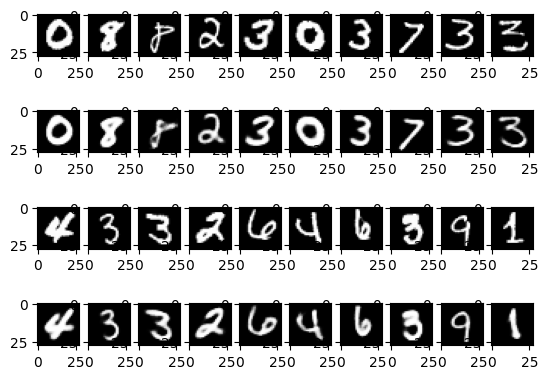

In [9]:
if batchnorm:
    autoencoder = models.load_model(f"saved_models/autoencoder_{LATSIZE}d_batchnorm", compile=False)
else:
    autoencoder = models.load_model(f"saved_models/autoencoder_{LATSIZE}d", compile=False)

_, ax = plt.subplots(4, 10)

for i in range(10):
    sample_ind = random.choice(range(len(train_x)))
    sampx, sampy = train_x[sample_ind], train_y[sample_ind]
    pred = autoencoder.predict([np.array([sampx]), np.array([sampy])], verbose=0)

    ax[0, i].imshow(sampx, cmap="gray")
    ax[1, i].imshow(pred[0], cmap="gray")

    sample_ind = random.choice(range(len(train_x)))
    sampx, sampy = train_x[sample_ind], train_y[sample_ind]
    pred = autoencoder.predict([np.array([sampx]), np.array([sampy])], verbose=0)

    ax[2, i].imshow(sampx, cmap="gray")
    ax[3, i].imshow(pred[0], cmap="gray")

plt.show()